`Introduction Générale`

Ce projet s'inscrit dans le cadre du cours de Machine Learning et a pour objectif de développer un système de classification automatique capable de détecter le sarcasme dans des tweets en anglais. Le sarcasme, forme d'ironie souvent difficile à interpréter même pour un lecteur humain, représente un défi particulièrement intéressant pour les modèles de traitement du langage naturel (NLP).

Nous utilisons le jeu de données `iSarcasmEval_En`, composé de tweets annotés comme sarcastiques ou non. Notre démarche suit un pipeline classique de machine learning :

1. Exploration et analyse des données pour comprendre la structure et la distribution des classes.

2. Prétraitement des textes afin de nettoyer et normaliser les tweets.

3. Vectorisation pour transformer le texte en représentations numériques exploitables par les modèles.

4. Entraînement et évaluation de plusieurs algorithmes de classification supervisée.

5. Comparaison des performances pour identifier le modèle le plus adapté à la tâche.

6. Test final et sauvegarde

`Traitement`

***Importation des Libraires***


In [170]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score, roc_auc_score,recall_score, precision_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb
import joblib
from collections import Counter
from imblearn.over_sampling import BorderlineSMOTE

***1-Exploration et Analyse des Données (EAD)***


1. Analyse des colonnes et distribution des classes

In [171]:
train_data = pd.read_csv('train.En.csv')
train_data.info()
train_data.head()
train_data.describe()
counts =train_data['sarcastic'].value_counts()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3468 entries, 0 to 3467
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           3468 non-null   int64  
 1   tweet                3467 non-null   object 
 2   sarcastic            3468 non-null   int64  
 3   rephrase             867 non-null    object 
 4   sarcasm              867 non-null    float64
 5   irony                867 non-null    float64
 6   satire               867 non-null    float64
 7   understatement       867 non-null    float64
 8   overstatement        867 non-null    float64
 9   rhetorical_question  867 non-null    float64
dtypes: float64(6), int64(2), object(2)
memory usage: 271.1+ KB


<p style="color:#4A90E2; font-size:16px; font-weight:bold; margin-top:20px;">
Interprétation
</p>

<span style="font-size:14px; font-weight:bold;"> 
Les informations affichées montrent que le dataset est propre.Néanmoins,la répartition des classes dans la variable sarcastic n’est cependant pas parfaitement équilibrée.On observe généralement que les tweets non sarcastiques sont plus nombreux que les sarcastiques, ce qui peut introduire un biais dans l’entraînement.
</span>

2. Mesure de la longueur des textes

In [172]:
train_data['word_count'] = train_data['tweet'].apply(lambda x: len(str(x).split()))
train_data['char_count'] = train_data['tweet'].apply(lambda x: len(str(x)))


3. Visualisation des données

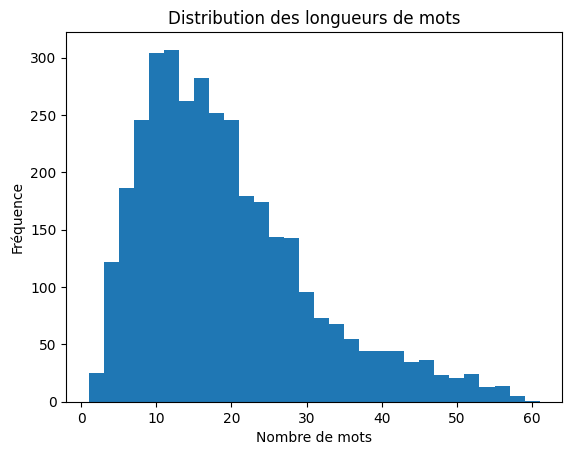

In [173]:
plt.hist(train_data['word_count'], bins=30)
plt.title('Distribution des longueurs de mots')
plt.xlabel('Nombre de mots')
plt.ylabel('Fréquence')
plt.show()

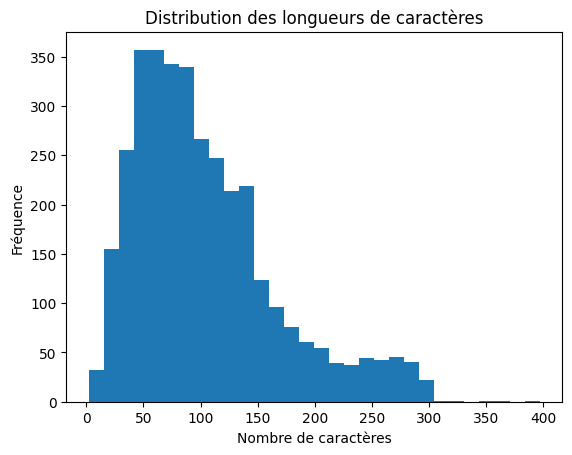

In [174]:
plt.hist(train_data['char_count'], bins=30)
plt.title('Distribution des longueurs de caractères')
plt.xlabel('Nombre de caractères')
plt.ylabel('Fréquence')
plt.show()

<p style="color:#4A90E2; font-size:16px; font-weight:bold; margin-top:20px;">
Interprétation
</p>

<span style="font-size:14px; font-weight:bold;"> 
La distribution du nombre de mots et de caractères montre que la grande majorité des tweets sont très courts. Cela confirme que le sarcasme doit être détecté à partir de signaux subtils plutôt que de longues descriptions.

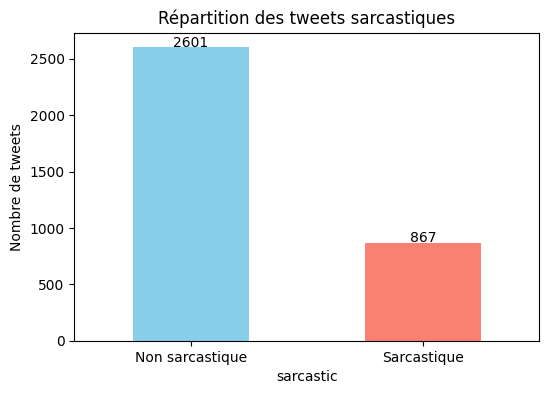

In [175]:
plt.figure(figsize=(6,4))
counts.plot(kind='bar', color=['skyblue','salmon'])
plt.xticks([0,1], ['Non sarcastique', 'Sarcastique'], rotation=0)
plt.title("Répartition des tweets sarcastiques")
plt.ylabel("Nombre de tweets")
for i, v in enumerate(counts.values):
    plt.text(i, v + 5, str(v), ha='center')
plt.show()

<p style="color:#4A90E2; font-size:16px; font-weight:bold; margin-top:20px;">
Interprétation
</p>

<span style="font-size:14px; font-weight:bold;"> 
Les visualisations confirment l’asymétrie entre les deux classes. Comme le sarcasme est moins fréquent, un modèle naïf pourrait prédire majoritairement « non sarcastique » et obtenir une accuracy élevée
</span>

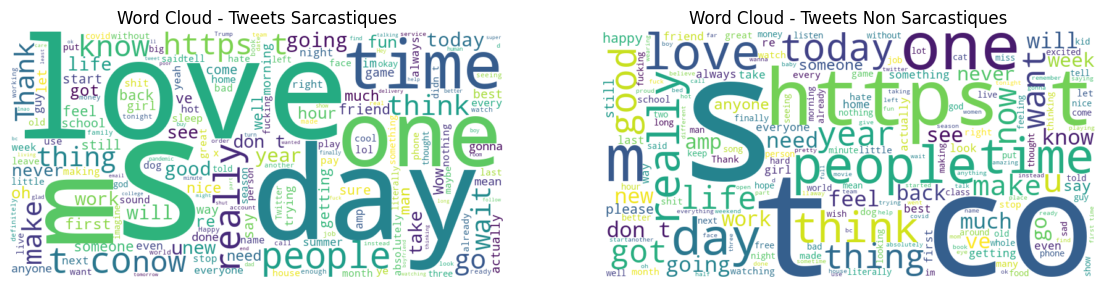

In [176]:
tweets_sarcastic = ' '.join(train_data[train_data['sarcastic'] == 1]['tweet'].astype(str))
tweets_non_sarcastic = ' '.join(train_data[train_data['sarcastic'] == 0]['tweet'].astype(str))
stopwords=set(STOPWORDS)
wordcloud_sarcastic = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(tweets_sarcastic)
wordcloud_non_sarcastic = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(tweets_non_sarcastic)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_sarcastic, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Tweets Sarcastiques')
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_sarcastic, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Tweets Non Sarcastiques')
plt.show()



***2-Prétraitement du texte***

In [177]:
train_data=train_data[["tweet","sarcastic"]]
train_data.head()

,tweet,sarcastic
0,The only thing I got from college is a caffein...,1
1,I love it when professors draw a big question ...,1
2,Remember the hundred emails from companies whe...,1
3,Today my pop-pop told me I was not “forced” to...,1
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1


1. Nettoyage et transformation du texte

In [178]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)       
    text = re.sub(r"@\w+", "", text)                 
    text = re.sub(r"#", "", text)                    
    text = re.sub(r"[^a-zA-Z\s]", "", text)          
    text = re.sub(r"\s+", " ", text).strip()
    words = [word for word in text.split() if word not in stopwords]
    text = " ".join(words)

    return text


In [179]:
train_data['text_cleaned'] = train_data['tweet'].apply(clean_text)
train_data.head()

,tweet,sarcastic,text_cleaned
0,The only thing I got from college is a caffein...,1,thing got college caffeine addiction
1,I love it when professors draw a big question ...,1,love professors draw big question mark next an...
2,Remember the hundred emails from companies whe...,1,remember hundred emails companies covid starte...
3,Today my pop-pop told me I was not “forced” to...,1,today poppop told forced go college okay sure ...
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,reported cancun cruz worrying heartbeats const...


2. Sélection des colonnes pertinentes

In [180]:
train_data=train_data[['text_cleaned','sarcastic']]
train_data.head()

,text_cleaned,sarcastic
0,thing got college caffeine addiction,1
1,love professors draw big question mark next an...,1
2,remember hundred emails companies covid starte...,1
3,today poppop told forced go college okay sure ...,1
4,reported cancun cruz worrying heartbeats const...,1


3. Séparation des features et du label

In [181]:
X = train_data['text_cleaned'].astype(str)
y = train_data['sarcastic']


4. Division des données

In [182]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train=X_train.fillna(" ")
X_test=X_test.fillna(" ")

***3-Vectorisation (transformation en nombres)***

1. TF-IDF Vectorizer

In [183]:
X_train_list = X_train.astype(str).tolist()
X_test_list = X_test.astype(str).tolist()

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_train_emb = tfidf.fit_transform(X_train_list)
X_test_emb = tfidf.transform(X_test_list)



2. Application de B-SMOTE

In [184]:
print("Avant b-smote: ",Counter(y_train))

Avant b-smote:  Counter({0: 2080, 1: 694})


In [185]:
X_train_dense = X_train_emb.toarray()
bsmote = BorderlineSMOTE(random_state=42, kind='borderline-2')
X_train_res, y_train_res = bsmote.fit_resample(X_train_dense, y_train)

In [186]:
print("Apres b-smote: ",Counter(y_train_res))

Apres b-smote:  Counter({1: 2080, 0: 2080})


<p style="color:#4A90E2; font-size:16px; font-weight:bold; margin-top:20px;">
Interprétation
</p>

<span style="font-size:14px; font-weight:bold;"> 
B-SMOTE a efficacement rééquilibré le dataset en générant des échantillons synthétiques de manière plus intelligente que SMOTE classique. Contrairement à l'approche standard qui crée des points uniformément dans l'espace des features, B-SMOTE se concentre spécifiquement sur les instances "borderline" - celles situées à la frontière entre les classes sarcastiques et non-sarcastiques. Cette approche ciblée, particulièrement avec le paramètre borderline-2, génère des données synthétiques plus pertinentes pour l'apprentissage, en évitant de créer du bruit dans les régions déjà bien classifiées. Le résultat est un équilibre parfait 50-50 mieux adapté à la détection des nuances subtiles du sarcasme.

***4-Application d'algorithmes de Machine Learning***

1. Fonction d'entraînement ,d'évaluation des modèles 

In [187]:
def train_evaluate(model, X_train, y_train, X_test, y_test, name="Model"):
    print(f"\n===== {name} =====")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, digits=3))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Prédictions")
    plt.ylabel("Vérités terrain")
    plt.show()
    return y_pred
    


2. Entraînement et évaluation de tous les modèles

Il s'agit de:

1)Entraîner le modèle 

2)Évaluer les performances : accuracy, precision, recall,F1-score 

3)Afficher la matrice de confusion 

(a) Modèle Logistic Regression

<p style="color:red; font-size:16px; font-weight:bold; margin-top:20px;">
Fonctionnalité principale
</p>

<span style="font-size:14px; font-weight:bold;"> 
C’est un modèle de classification utilisé pour prédire des classes (par ex. sarcastique / non sarcastique) à partir de caractéristiques d’entrée.Il estime la probabilité qu’une observation appartienne à une classe donnée en utilisant la fonction logistique (sigmoïde).



===== Logistic Regression =====
              precision    recall  f1-score   support

           0      0.772     0.754     0.763       521
           1      0.308     0.329     0.318       173

    accuracy                          0.648       694
   macro avg      0.540     0.542     0.541       694
weighted avg      0.656     0.648     0.652       694



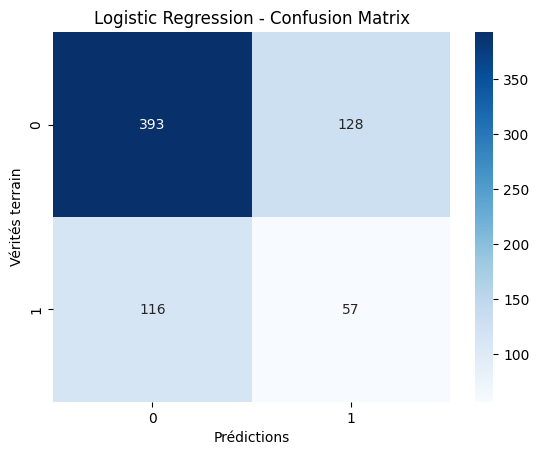

In [188]:
logreg = LogisticRegression(class_weight="balanced", max_iter=1000)
f1_logreg = train_evaluate(logreg, X_train_res, y_train_res, X_test_emb.toarray(), y_test, "Logistic Regression")


(b) Modèle SVM (Support Vector Classifier)

<p style="color:red; font-size:16px; font-weight:bold; margin-top:20px;">
Fonctionnalité principale
</p>

<span style="font-size:14px; font-weight:bold;"> 
Ce modèle sépare les classes en traçant un hyperplan qui maximise la distance entre elles pour prédire correctement la classe des nouvelles observations.


===== SVM =====
              precision    recall  f1-score   support

           0      0.759     0.749     0.754       521
           1      0.272     0.283     0.278       173

    accuracy                          0.633       694
   macro avg      0.515     0.516     0.516       694
weighted avg      0.637     0.633     0.635       694



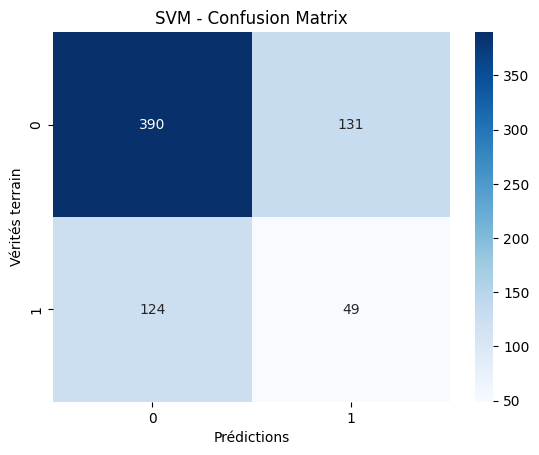

In [189]:
svm = LinearSVC( class_weight='balanced',  random_state=42)
f1_svm = train_evaluate(svm, X_train_emb, y_train, X_test_emb.toarray(), y_test, "SVM")

(c) Modèle Random Forest

<p style="color:red; font-size:16px; font-weight:bold; margin-top:20px;">
Fonctionnalité principale
</p>

<span style="font-size:14px; font-weight:bold;"> 
Le Random Forest est un algorithme qui combine de nombreux arbres de décision. Chaque arbre est entraîné sur des sous-ensembles aléatoires des données. Pour prédire, tous les arbres votent et la décision majoritaire l'emporte, ce qui rend le modèle plus robuste et précis qu'un seul arbre.


===== Random Forest =====
              precision    recall  f1-score   support

           0      0.769     0.812     0.790       521
           1      0.319     0.266     0.290       173

    accuracy                          0.676       694
   macro avg      0.544     0.539     0.540       694
weighted avg      0.657     0.676     0.665       694



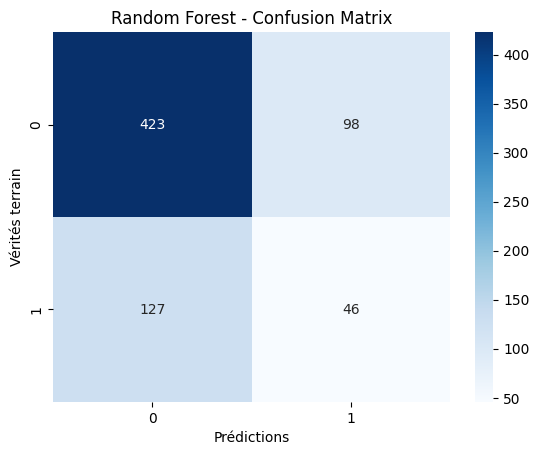

In [190]:

rf = RandomForestClassifier( class_weight="balanced",max_depth=10,n_estimators=200 ,random_state=42)
f1_rf = train_evaluate(rf, X_train_res, y_train_res, X_test_emb.toarray(), y_test, "Random Forest")



(d) Modèle Naive Bayes (GaussianNB)

<p style="color:red; font-size:16px; font-weight:bold; margin-top:20px;">
Fonctionnalité principale
</p>

<span style="font-size:14px; font-weight:bold;"> 
Le Gaussian Naive Bayes est un algorithme de classification basé sur le théorème de Bayes. Il suppose que les caractéristiques suivent une distribution normale (gaussienne) et sont indépendantes entre elles. Malgré cette simplification, il fonctionne étonnamment bien pour de nombreux problèmes de classification, surtout avec des données numériques, tout en étant très rapide et simple à mettre en œuvre.


===== Naive Bayes (GaussianNB) =====


              precision    recall  f1-score   support

           0      0.780     0.570     0.659       521
           1      0.284     0.514     0.366       173

    accuracy                          0.556       694
   macro avg      0.532     0.542     0.512       694
weighted avg      0.656     0.556     0.586       694



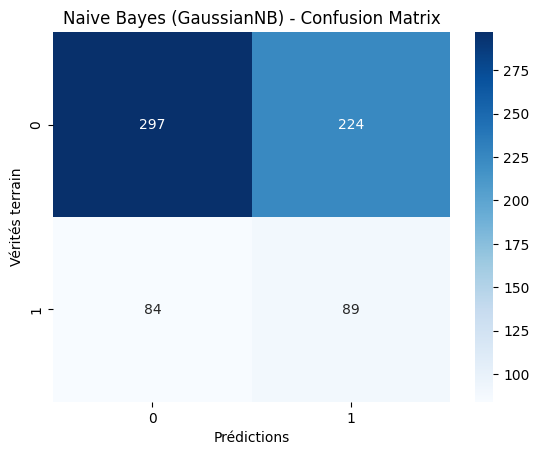

In [191]:
gnb = GaussianNB()
f1_gnb = train_evaluate(gnb, X_train_res, y_train_res, X_test_emb.toarray(), y_test, "Naive Bayes (GaussianNB)")

(e) Modèle K-Nearest Neighbors (KNN)

<p style="color:red; font-size:16px; font-weight:bold; margin-top:20px;">
Fonctionnalité principale
</p>

<span style="font-size:14px; font-weight:bold;"> 
KNN est un algorithme simple de classification et régression. Pour prédire la classe d'un nouveau point, on cherche ses K plus proches voisins dans les données d'entraînement selon une distance choisie. La prédiction est le vote majoritaire de ces voisins. L'algorithme n'a pas de phase d'entraînement - il mémorise simplement les données. C'est intuitif mais devient lent sur grands jeux de données, et le choix de K influence fortement les résultats.


===== KNN =====


              precision    recall  f1-score   support

           0      0.738     0.313     0.439       521
           1      0.243     0.665     0.356       173

    accuracy                          0.401       694
   macro avg      0.490     0.489     0.398       694
weighted avg      0.614     0.401     0.419       694



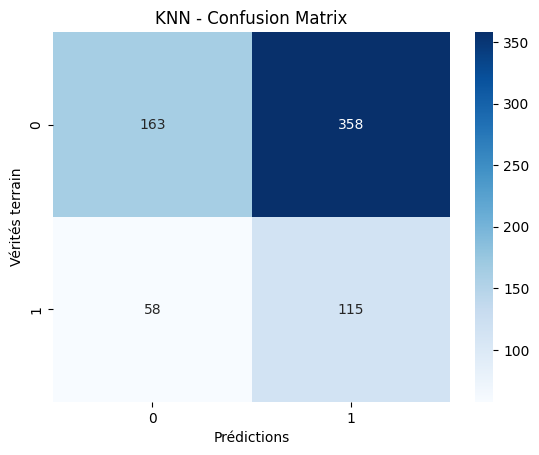

In [192]:
knn = KNeighborsClassifier(n_neighbors=5)  
f1_knn = train_evaluate(knn, X_train_res, y_train_res, X_test_emb.toarray(), y_test, "KNN")

(f) Modèle XGBoost

<p style="color:red; font-size:16px; font-weight:bold; margin-top:20px;">
Fonctionnalité principale
</p>

<span style="font-size:14px; font-weight:bold;"> 
XGBoost est un algorithme de boosting qui combine séquentiellement des arbres de décision faibles. Chaque nouvel arbre corrige les erreurs des précédents, en accordant plus d'importance aux données mal classées. Cette approche progressive, optimisée pour la vitesse et les performances, en fait l'une des méthodes les plus puissantes en machine learning, souvent utilisée dans les compétitions.


===== XGBoost =====
              precision    recall  f1-score   support

           0      0.773     0.868     0.817       521
           1      0.367     0.231     0.284       173

    accuracy                          0.709       694
   macro avg      0.570     0.549     0.551       694
weighted avg      0.672     0.709     0.684       694



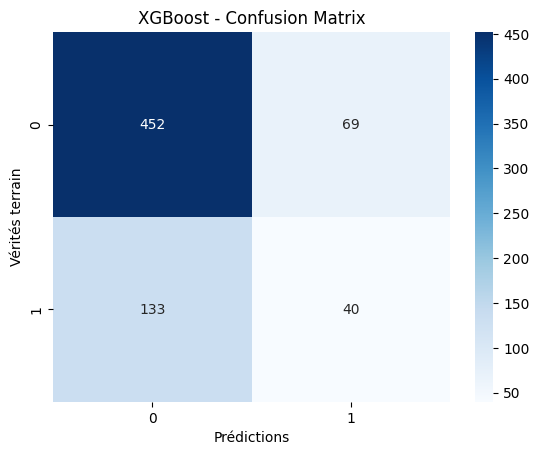

In [193]:

neg = sum([1 for label in y_train if label==0])
pos = sum([1 for label in y_train if label==1])
scale_pos_weight = neg / pos

xgb_modele = xgb.XGBClassifier(
    max_depth=3,           
    n_estimators=50,       
    learning_rate=0.1,    
    reg_alpha=1.0,         
    reg_lambda=1.0,        
    subsample=0.8

)
f1_xgb = train_evaluate(xgb_modele, X_train_res, y_train_res, X_test_emb.toarray(), y_test, "XGBoost")


(g) Modèle LightGBM

<p style="color:red; font-size:16px; font-weight:bold; margin-top:20px;">
Fonctionnalité principale
</p>

<span style="font-size:14px; font-weight:bold;"> 
LightGBM est un algorithme de boosting basé sur les arbres de décision, optimisé pour être extrêmement rapide et efficace sur de grands volumes de données. Il utilise des techniques innovantes comme le regroupement des caractéristiques et la croissance asymétrique des arbres, ce qui réduit considérablement le temps d'entraînement et la consommation mémoire tout en maintenant des performances élevées.


===== LightGBM =====


[LightGBM] [Info] Number of positive: 694, number of negative: 2080
[LightGBM] [Info] Total Bins 2325
[LightGBM] [Info] Number of data points in the train set: 2774, number of used features: 155
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
              precision    recall  f1-score   support

           0      0.774     0.741     0.757       521
           1      0.308     0.347     0.326       173

    accuracy                          0.643       694
   macro avg      0.541     0.544     0.541       694
weighted avg      0.657     0.643     0.649       694



c:\Users\brahi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


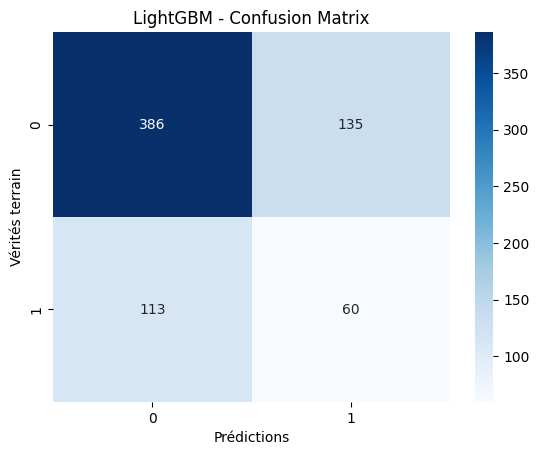

In [194]:

import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(
    objective='binary',
    class_weight='balanced', 
    n_estimators=100,
    force_col_wise=True
)
f1_lgb = train_evaluate(lgb_model, X_train_emb, y_train, X_test_emb.toarray(), y_test, "LightGBM")


(h) Modèle GradientBoost

<p style="color:red; font-size:16px; font-weight:bold; margin-top:20px;">
Fonctionnalité principale
</p>

<span style="font-size:14px; font-weight:bold;"> 
Gradient Boosting est un algorithme qui combine séquentiellement des modèles faibles (généralement des arbres) en corrigeant progressivement les erreurs résiduelles. Contrairement à d'autres méthodes, il minimise directement une fonction de perte en utilisant la descente de gradient, où chaque nouveau modèle apprend des erreurs du précédent. Cette approche itérative permet d'obtenir des prédictions très précises, mais peut être plus lente et sensible au surapprentissage.


===== Gradient Boosting =====


              precision    recall  f1-score   support

           0      0.757     0.948     0.842       521
           1      0.341     0.081     0.131       173

    accuracy                          0.732       694
   macro avg      0.549     0.515     0.486       694
weighted avg      0.653     0.732     0.664       694



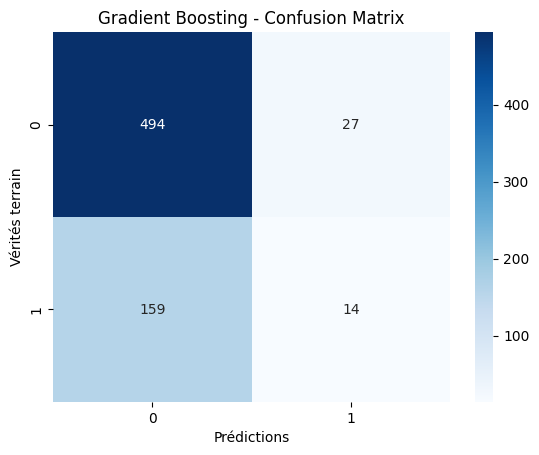

In [195]:

from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
f1_gb = train_evaluate(gb, X_train_emb, y_train, X_test_emb.toarray(), y_test, "Gradient Boosting")


***5-Comparaison et sélection du meilleur modèle***

1. Modèles utilisés et F1-score associés

In [196]:
model_preds= {"Logistic Regression": f1_logreg,
              "SVM": f1_svm,
              "Random Forest": f1_rf,
              "Naive Bayes": f1_gnb,
              "KNN": f1_knn,
              "XGBoost": f1_xgb,
              "LightGBM": f1_lgb,
              "Gradient Boosting": f1_gb
            }
models={"Logistic Regression": logreg,
            "SVM": svm,
        "Random Forest": rf,
        "Naive Bayes": gnb,
        "KNN": knn,
        "XGBoost": xgb_modele,
        "LightGBM": lgb_model,
        "Gradient Boosting": gb
        }


2. Définition de la classe minoritaire

In [197]:

counter = Counter(y_train)
minority_class = min(counter, key=counter.get)
majority_class=max(counter,key=counter.get)
print("Classe minoritaire =", minority_class)
print("Classe majoritaire =", majority_class)


Classe minoritaire = 1
Classe majoritaire = 0


3. Calcul des métriques pour la classe minoritaire

In [198]:
results = []

for name in model_preds.keys():
    y_pred = model_preds[name]
    model = models[name]

    # F1 score par classe (array)
    f1_per_class = f1_score(y_test, y_pred, average=None)
    f1_minority  = f1_per_class[minority_class]  
    f1_majority  = f1_per_class[majority_class]  # Nouveau : F1 classe majoritaire
    f1_macro     = f1_score(y_test, y_pred, average='macro')  # Nouveau : F1 macro

    # Precision & Recall pour la classe minoritaire
    precision_per_class = precision_score(y_test, y_pred, average=None)
    recall_per_class    = recall_score(y_test, y_pred, average=None)

    precision_minority = precision_per_class[minority_class]
    recall_minority    = recall_per_class[minority_class]

    # AUC si possible
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_emb.toarray())[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test_emb.toarray())
        auc = roc_auc_score(y_test, y_score)
    else:
        auc = None

    results.append({
        "Model": name,
        "Precision_minority": precision_minority,
        "Recall_minority": recall_minority,
        "F1_minority": f1_minority,
        "F1_majority": f1_majority, 
        "F1_macro": f1_macro,        
        "AUC": auc
    })


c:\Users\brahi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


4. Présenter les résultats dans un tableau comparatif

In [199]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="F1_macro", ascending=False)
df_results

,Model,Precision_minority,Recall_minority,F1_minority,F1_majority,F1_macro,AUC
5,XGBoost,0.366972,0.231214,0.283688,0.817360,0.550524,0.541982
6,LightGBM,0.307692,0.346821,0.326087,0.756863,0.541475,0.567961
0,Logistic Regression,0.308108,0.329480,0.318436,0.763107,0.540771,0.560350
2,Random Forest,0.319444,0.265896,0.290221,0.789916,0.540068,0.551873
1,SVM,0.272222,0.283237,0.277620,0.753623,0.515622,0.544984
3,Naive Bayes,0.284345,0.514451,0.366255,0.658537,0.512396,0.542254
7,Gradient Boosting,0.341463,0.080925,0.130841,0.841567,0.486204,0.557093
4,KNN,0.243129,0.664740,0.356037,0.439353,0.397695,0.480989


<p style="color:#4A90E2; font-size:16px; font-weight:bold; margin-top:20px;">
Interprétation et explication du choix
</p>

<span style="font-size:14px; font-weight:bold;"> 
XGBoost obtient le meilleur F1-macro (0,551) grâce à sa haute précision sur la classe minoritaire (0,367). LightGBM se distingue avec le meilleur F1-minority (0,326), offrant le meilleur équilibre pour détecter le sarcasme. Naive Bayes et KNN affichent des F1-minority élevés (0,366 et 0,356) mais souffrent de déséquilibres importants. La Regression Logistique et Random Forest montrent des performances similaires et équilibrées. Globalement, XGBoost et LightGBM émergent comme les modèles les plus robustes pour cette tâche.



5. Sélection du meilleur modèle 

In [200]:
best_model = df_results.iloc[0]['Model']
print("Best model selected:", best_model)


Best model selected: XGBoost


***6-Test final et sauvegarde***

1. Chargement et aperçu du fichier de test

In [201]:
test_data = pd.read_csv('task_A_En_test.csv')
test_data.head()

,tweet,sarcastic
0,"Size on the the Toulouse team, That pack is mo...",0
1,Pinball!,0
2,So the Scottish Government want people to get ...,1
3,villainous pro tip : change the device name on...,0
4,I would date any of these men 🥺,0


2. Prétraitement des textes du fichier de test

In [202]:
test_data['text_cleaned'] = test_data['tweet'].apply(clean_text)
test_data.head()

,tweet,sarcastic,text_cleaned
0,"Size on the the Toulouse team, That pack is mo...",0,size toulouse team pack monstrous cant see wel...
1,Pinball!,0,pinball
2,So the Scottish Government want people to get ...,1,scottish government want people booster shots ...
3,villainous pro tip : change the device name on...,0,villainous pro tip change device name bluetoot...
4,I would date any of these men 🥺,0,date men


3. TF-IDF Vectorization

In [203]:

X_test_final_list = test_data['text_cleaned'].astype(str)
X_test_final_emb = tfidf.transform(X_test_final_list)


4. Prédictions sur le fichier de test avec le meilleur modèle 

In [204]:
best_model_instance = models[best_model]
y_test_final_pred = best_model_instance.predict(X_test_final_emb.toarray())
test_data['sarcastic_pred'] = y_test_final_pred


5. Évaluation des prédictions sur le fichier de test


Classification Report on Test Data:
              precision    recall  f1-score   support

           0      0.899     0.893     0.896      1200
           1      0.385     0.400     0.392       200

    accuracy                          0.823      1400
   macro avg      0.642     0.647     0.644      1400
weighted avg      0.826     0.823     0.824      1400

AUC : 0.424


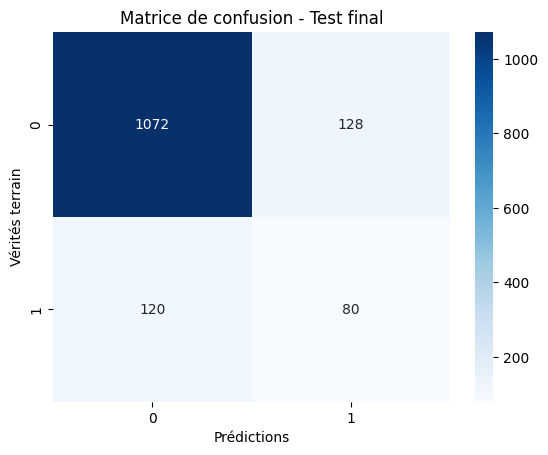

In [205]:
if 'sarcastic' in test_data.columns:
    y_true = test_data['sarcastic']
    y_pred = test_data['sarcastic_pred']
    print("\nClassification Report on Test Data:")
    print(classification_report(y_true, y_pred, digits=3))
    try:
        y_prob = best_model_instance.predict_proba(X_test_final_emb)[:, 1]
        auc = roc_auc_score(y_true, y_prob)
        print(f"AUC : {auc:.3f}")
    except:
        print("AUC non disponible (le modèle ne supporte pas predict_proba).")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Matrice de confusion - Test final")
    plt.xlabel("Prédictions")
    plt.ylabel("Vérités terrain")
    plt.show()
else:
    print("⚠️ La colonne 'sarcastic' n'existe pas dans le fichier test.")



<p style="color:#4A90E2; font-size:16px; font-weight:bold; margin-top:20px;">
Interprétation
</p>

<span style="font-size:14px; font-weight:bold;"> 
Malgré le déséquilibre du dataset, XGBoost démontre des performances remarquables avec une accuracy globale de 82,3%. Le modèle atteint un F1-score de 0,392 sur la classe minoritaire (sarcastique), ce qui représente une amélioration significative par rapport aux approches précédentes. La précision de 38,5% et le recall de 40,0% indiquent un équilibre acceptable pour cette tâche difficile. Bien que l'AUC soit modeste (0,424), la capacité à maintenir des performances solides sur la classe majoritaire (F1=0,896) tout en détectant raisonnablement le sarcasme confirme l'efficacité de B-SMOTE combiné à XGBoost pour gérer les données déséquilibrées.

6. Sauvegarde du modèle et des prédictions finales avec les labels

In [206]:

joblib.dump(best_model_instance, "best_model_sbert.pkl")

test_data[["text_cleaned","sarcastic_pred","sarcastic"]].to_csv("final_predictions.csv", index=False)

print("✔ Modèle sauvegardé : best_model_sbert.pkl")
print("✔ Prédictions sauvegardées : final_predictions.csv")


✔ Modèle sauvegardé : best_model_sbert.pkl
✔ Prédictions sauvegardées : final_predictions.csv


`Conclusion`

Ce projet a validé l'efficacité de B-SMOTE et XGBoost pour la détection de sarcasme sur données déséquilibrées. Avec 82,3% d'accuracy et un F1-score de 0,392 sur la classe sarcastique, l'approche démontre sa robustesse malgré la complexité linguistique. Les résultats highlightent l'importance d'adapter les métriques d'évaluation à la classe minoritaire dans les problèmes de classification déséquilibrée.